Imports


In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

Generate Random Dataset (see writup for full details)


Synthetic dataset preview:
        DATE  LOCATION_ID   ELEVATION  MONTH  SEASON      T.MAX      T.MIN  \
0 2020-01-01            1  305.926447      1       1  13.313137   8.491925   
1 2020-01-02            1  305.926447      1       1  11.608343   7.584431   
2 2020-01-03            1  305.926447      1       1  15.403287  13.563555   
3 2020-01-04            1  305.926447      1       1  16.746368  11.506667   
4 2020-01-05            1  305.926447      1       1  17.663245  12.890704   

     T.MIN.G      RAIN  IND  IND.1  IND.2       WIND  
0   6.844725  0.357255    0      0      0  14.397783  
1   3.851079  0.293735    0      0      0  11.971705  
2  12.042390  1.657731    0      0      0  12.197383  
3  10.068087  1.517064    0      0      0  14.910694  
4  10.760437  1.418309    0      0      0  15.764293  

Descriptive statistics:
                      DATE  LOCATION_ID    ELEVATION        MONTH  \
count                 7500  7500.000000  7500.000000  7500.000000   
mean   202

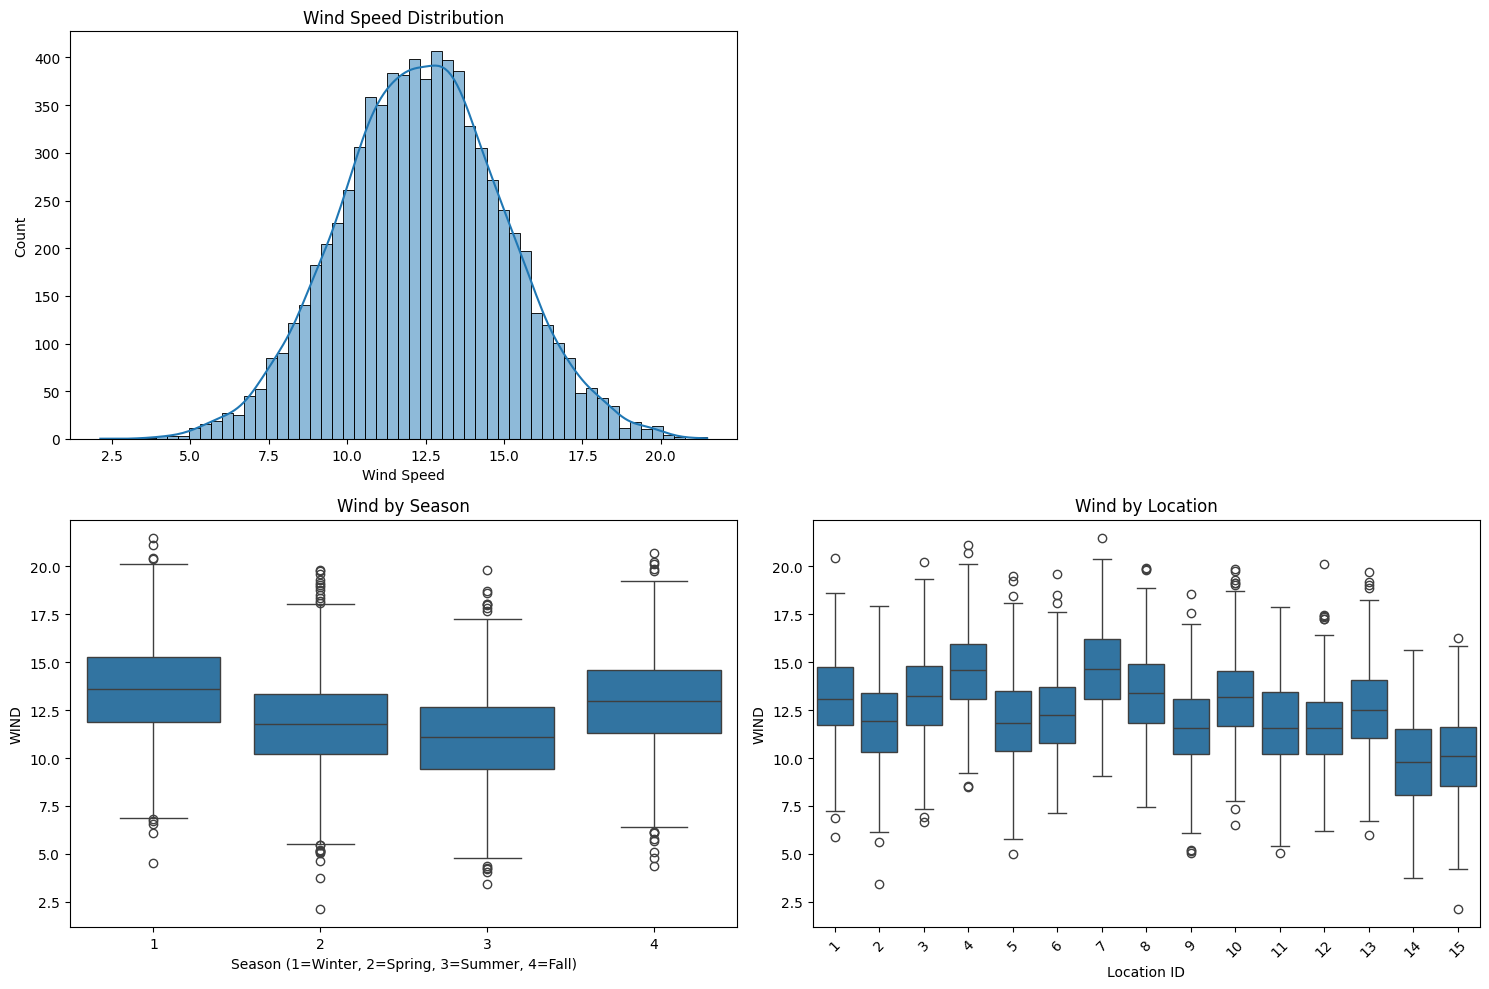

In [ ]:
# Number of observations per location
n_obs = 500

# Number of locations
n_locations = 15

# True parameter values (for generation)
true_alpha = 12.0                            # Global intercept
true_beta_rain = 0.3                         # Effect of rain
true_beta_tmax = -0.2                        # Effect of max temperature
true_beta_tmin = 0.1                         # Effect of min temperature
true_beta_tmin_g = -0.05                     # Effect of ground min temperature
true_beta_elevation = 0.15                   # Effect of elevation

# Location specific componants
true_location_sigmas = 1.5
true_location_intercepts = np.random.normal(0, true_location_sigmas, n_locations)

# Season effects
true_season_effects = np.array([1.5, 0.0, -1.0, 0.5])

# SD of noise
true_sigma = 2.0

# dates
start_date = datetime(2020, 1, 1)
dates = [start_date + timedelta(days=i) for i in range(n_obs)]

# Location generation
locations = pd.DataFrame({
    'LOCATION_ID': range(1, n_locations + 1),
    'ELEVATION': np.random.uniform(0, 500, n_locations),
    'LAT': np.random.uniform(50.0, 52.0, n_locations),
    'LON': np.random.uniform(-1.0, 1.0, n_locations)
})

# Actually storing the data
all_data = []

for loc_id in range(1, n_locations + 1):
    location_idx = loc_id - 1
    loc_intercept = true_location_intercepts[location_idx]
    elevation = locations.loc[locations['LOCATION_ID'] == loc_id, 'ELEVATION'].values[0]

    loc_df = pd.DataFrame({
        'DATE': dates,
        'LOCATION_ID': loc_id,
        'ELEVATION': elevation
    })

    loc_df['MONTH'] = pd.to_datetime(loc_df['DATE']).dt.month
    loc_df['SEASON'] = ((loc_df['MONTH'] % 12) // 3 + 1).astype(int)

    loc_df['T.MAX'] = 15 + 10 * np.sin(2 * np.pi * (loc_df['MONTH'] - 1) / 12) + np.random.normal(0, 3, n_obs)
    loc_df['T.MIN'] = loc_df['T.MAX'] - 5 - 3 * np.sin(2 * np.pi * (loc_df['MONTH'] - 1) / 12) + np.random.normal(0, 2, n_obs)
    loc_df['T.MIN.G'] = loc_df['T.MIN'] - 2 + np.random.normal(0, 1.5, n_obs)

    # Vary rain by season to be more accurate
    rainfall_seasonal = 5 - 3 * np.sin(2 * np.pi * (loc_df['MONTH'] - 1) / 12)
    loc_df['RAIN'] = np.maximum(0, np.random.exponential(rainfall_seasonal, n_obs))

    # Create the variables found in the original dataset
    loc_df['IND'] = (np.random.random(n_obs) < 0.2).astype(int)
    loc_df['IND.1'] = (loc_df['RAIN'] > 5).astype(int)
    loc_df['IND.2'] = (loc_df['T.MAX'] > 20).astype(int)

    # Standardize the weather variables
    loc_df['RAIN_std'] = (loc_df['RAIN'] - loc_df['RAIN'].mean()) / loc_df['RAIN'].std() if loc_df['RAIN'].std() > 0 else 0
    loc_df['T.MAX_std'] = (loc_df['T.MAX'] - loc_df['T.MAX'].mean()) / loc_df['T.MAX'].std() if loc_df['T.MAX'].std() > 0 else 0
    loc_df['T.MIN_std'] = (loc_df['T.MIN'] - loc_df['T.MIN'].mean()) / loc_df['T.MIN'].std() if loc_df['T.MIN'].std() > 0 else 0
    loc_df['T.MIN.G_std'] = (loc_df['T.MIN.G'] - loc_df['T.MIN.G'].mean()) / loc_df['T.MIN.G'].std() if loc_df['T.MIN.G'].std() > 0 else 0
    loc_df['ELEVATION_std'] = (loc_df['ELEVATION'] - locations['ELEVATION'].mean()) / locations['ELEVATION'].std() if locations['ELEVATION'].std() > 0 else 0

    # Generate wind variables based on the dataset we found and simulated data
    season_idx = loc_df['SEASON'] - 1
    loc_df['WIND'] = (
        true_alpha +
        loc_intercept +
        true_season_effects[season_idx] +
        true_beta_rain * loc_df['RAIN_std'] +
        true_beta_tmax * loc_df['T.MAX_std'] +
        true_beta_tmin * loc_df['T.MIN_std'] +
        true_beta_tmin_g * loc_df['T.MIN.G_std'] +
        true_beta_elevation * loc_df['ELEVATION_std'] +
        np.random.normal(0, true_sigma, n_obs)
    )

    loc_df['WIND'] = np.maximum(0, loc_df['WIND'])
    loc_df = loc_df.drop(['RAIN_std', 'T.MAX_std', 'T.MIN_std', 'T.MIN.G_std', 'ELEVATION_std'], axis=1)
    all_data.append(loc_df)

# Combine all location data
combined_df = pd.concat(all_data, ignore_index=True)

# Preview data in notebook
print("\nSynthetic dataset preview:")
print(combined_df.head())

# Descriptive statistics
print("\nDescriptive statistics:")
print(combined_df.describe())


true_params = {
    'alpha': true_alpha,
    'beta_rain': true_beta_rain,
    'beta_tmax': true_beta_tmax,
    'beta_tmin': true_beta_tmin,
    'beta_tmin_g': true_beta_tmin_g,
    'beta_elevation': true_beta_elevation,
    'location_sigmas': true_location_sigmas,
    'location_intercepts': true_location_intercepts,
    'season_effects': true_season_effects,
    'sigma': true_sigma
}

# Visualizing the data
plt.figure(figsize=(15, 10))

# Plot wind distribution
plt.subplot(2, 2, 1)
sns.histplot(combined_df['WIND'], kde=True)
plt.title('Wind Speed Distribution')
plt.xlabel('Wind Speed')

# Plot wind by season
plt.subplot(2, 2, 3)
sns.boxplot(data=combined_df, x='SEASON', y='WIND')
plt.title('Wind by Season')
plt.xlabel('Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)')

# Plot wind by location
plt.subplot(2, 2, 4)
sns.boxplot(data=combined_df, x='LOCATION_ID', y='WIND')
plt.title('Wind by Location')
plt.xlabel('Location ID')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('dataset_exploration.png')

Now we make a baseline model. This is a non-heirarchical baysian model, with limited features. The features used are rain and max temperature in this case.

Output()


Simple Baseline Model Convergence Diagnostics:
             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha      12.384  0.030  12.330   12.442      0.001    0.001    2459.0   
beta_rain   0.337  0.031   0.283    0.398      0.001    0.001    2192.0   
beta_tmax  -0.252  0.031  -0.307   -0.192      0.001    0.001    2138.0   
sigma       2.574  0.021   2.537    2.616      0.000    0.000    2767.0   

           ess_tail  r_hat  
alpha        1257.0    1.0  
beta_rain    1395.0    1.0  
beta_tmax    1511.0    1.0  
sigma        1496.0    1.0  
R-hat range: 1.000 to 1.000
All parameters converged: True

Parameter Recovery (Baseline Model):
True alpha: 12.000, Estimated: 12.384
True beta_rain: 0.300, Estimated: 0.337
True beta_tmax: -0.200, Estimated: -0.252
True sigma: 2.000, Estimated: 2.574


Output()

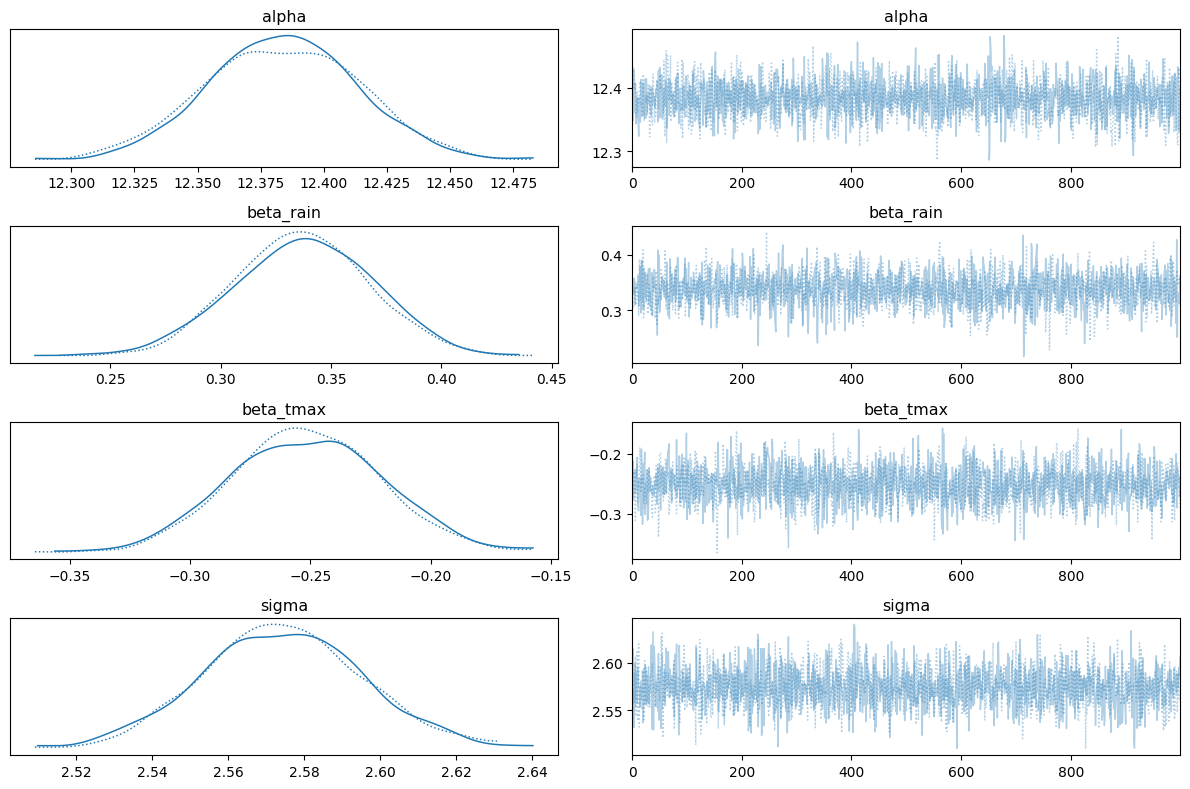

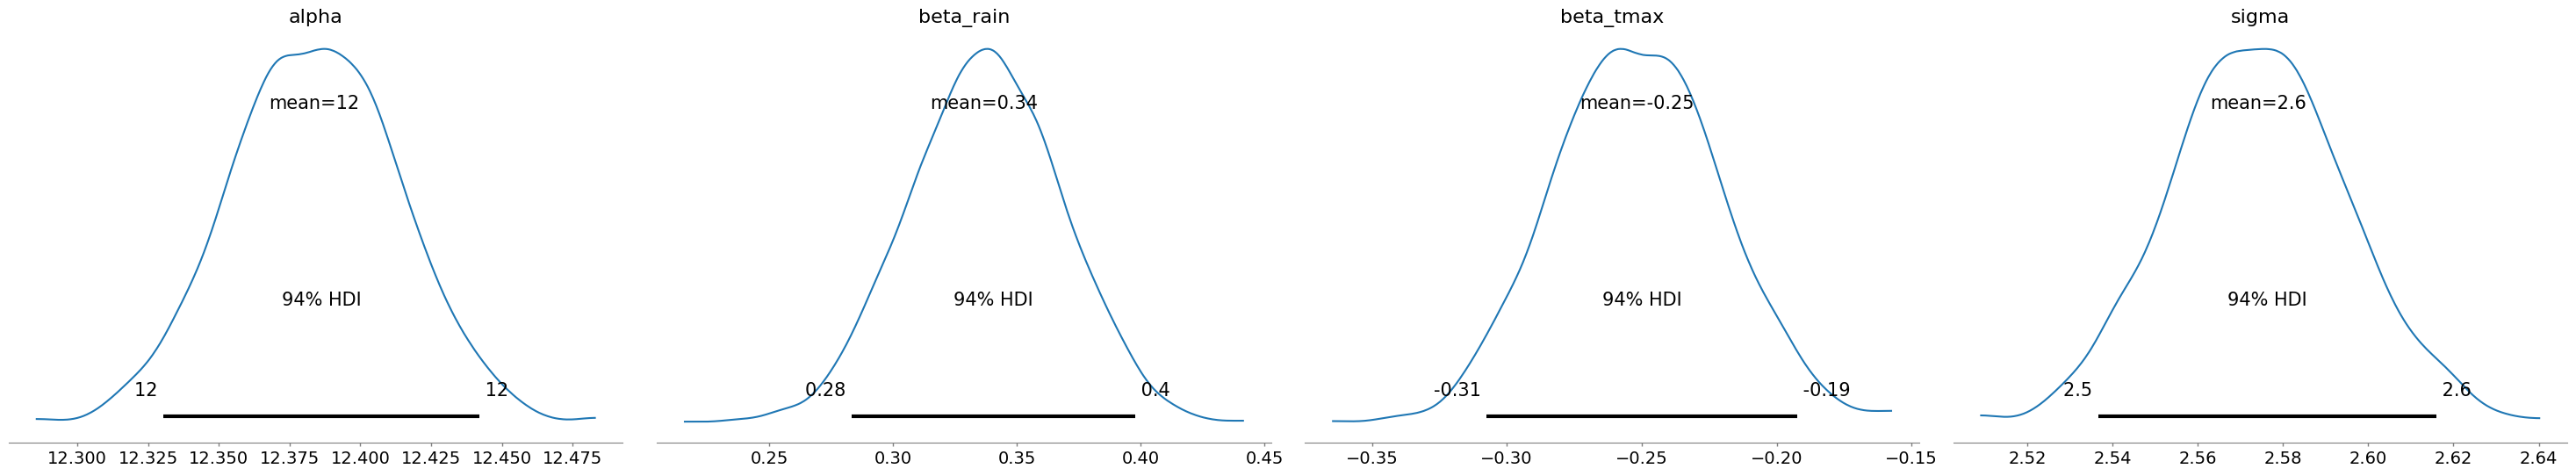

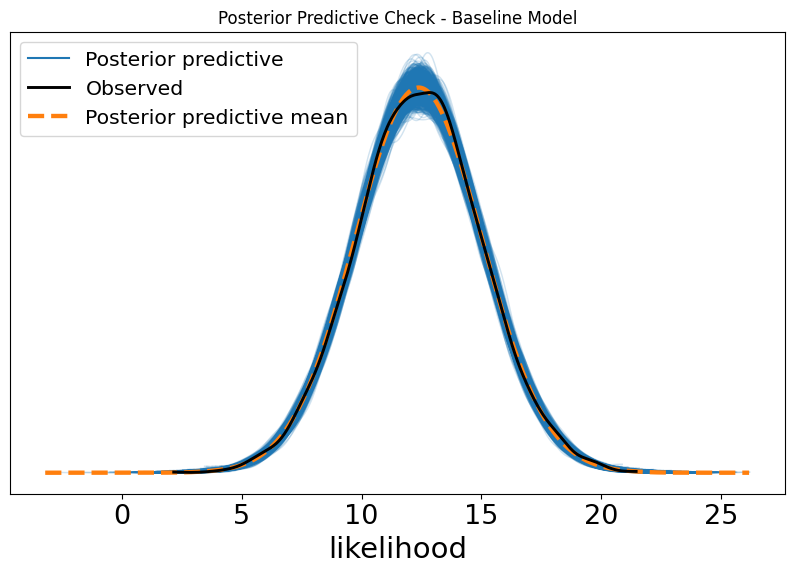

In [ ]:
# Prepare data
X_simple = combined_df[['RAIN', 'T.MAX']]
X_simple_std = (X_simple - X_simple.mean()) / X_simple.std()


y = combined_df['WIND'].values

# Building model (it is a smiple linear model)
with pm.Model() as baseline_model:

    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_rain = pm.Normal('beta_rain', mu=0, sigma=1)
    beta_tmax = pm.Normal('beta_tmax', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=5)

    #LINEAR DFINITION
    mu = alpha + beta_rain * X_simple_std['RAIN'].values + beta_tmax * X_simple_std['T.MAX'].values


    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)

    baseline_trace = pm.sample(1000, tune=1000, return_inferencedata=True,
                              target_accept=0.95, random_seed=42)


# Convergence diagnostics
print("\nSimple Baseline Model Convergence Diagnostics:")
summary_baseline = az.summary(baseline_trace)
print(summary_baseline)

# Check R-hat
rhat_vals_baseline = summary_baseline['r_hat'].values
print(f"R-hat range: {rhat_vals_baseline.min():.3f} to {rhat_vals_baseline.max():.3f}")
print(f"All parameters converged: {np.all(rhat_vals_baseline < 1.05)}")

# Visual aids to include in writeup
az.plot_trace(baseline_trace)
plt.tight_layout()
plt.savefig('baseline_trace.png')

az.plot_posterior(baseline_trace)
plt.tight_layout()
plt.savefig('baseline_posterior.png')

# Value comparison to originals
print("\nParameter Recovery (Baseline Model):")
print(f"True alpha: {true_alpha:.3f}, Estimated: {float(summary_baseline.loc['alpha', 'mean']):.3f}")
print(f"True beta_rain: {true_beta_rain:.3f}, Estimated: {float(summary_baseline.loc['beta_rain', 'mean']):.3f}")
print(f"True beta_tmax: {true_beta_tmax:.3f}, Estimated: {float(summary_baseline.loc['beta_tmax', 'mean']):.3f}")
print(f"True sigma: {true_sigma:.3f}, Estimated: {float(summary_baseline.loc['sigma', 'mean']):.3f}")

# Posterior predictive check
with baseline_model:
    baseline_ppc = pm.sample_posterior_predictive(baseline_trace)

az.plot_ppc(baseline_ppc, figsize=(10, 6))
plt.title("Posterior Predictive Check - Baseline Model")
plt.savefig('baseline_ppc.png')

The next step in the process is to build on the old model, using more features. This is still a non-heirarcical model, but it uses the majority of the features available in the data. The code is very similar, just using more features

Output()


Full Model Convergence Diagnostics:
                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha              12.058  1.490   9.212   14.888      0.066    0.042   
beta_elevation     -0.769  0.027  -0.817   -0.716      0.001    0.001   
beta_rain           0.302  0.028   0.251    0.355      0.001    0.001   
beta_tmax          -0.189  0.098  -0.365    0.005      0.002    0.002   
beta_tmin           0.095  0.132  -0.155    0.333      0.004    0.003   
beta_tmin_g        -0.023  0.109  -0.221    0.175      0.003    0.003   
season_effects[0]   1.490  1.489  -1.212    4.449      0.066    0.042   
season_effects[1]  -0.047  1.491  -2.908    2.761      0.066    0.042   
season_effects[2]  -1.064  1.488  -3.908    1.730      0.066    0.042   
season_effects[3]   0.498  1.491  -2.364    3.276      0.066    0.042   
sigma               2.290  0.018   2.256    2.325      0.000    0.000   

                   ess_bulk  ess_tail  r_hat  
alpha                 503.0     697.0  

Output()

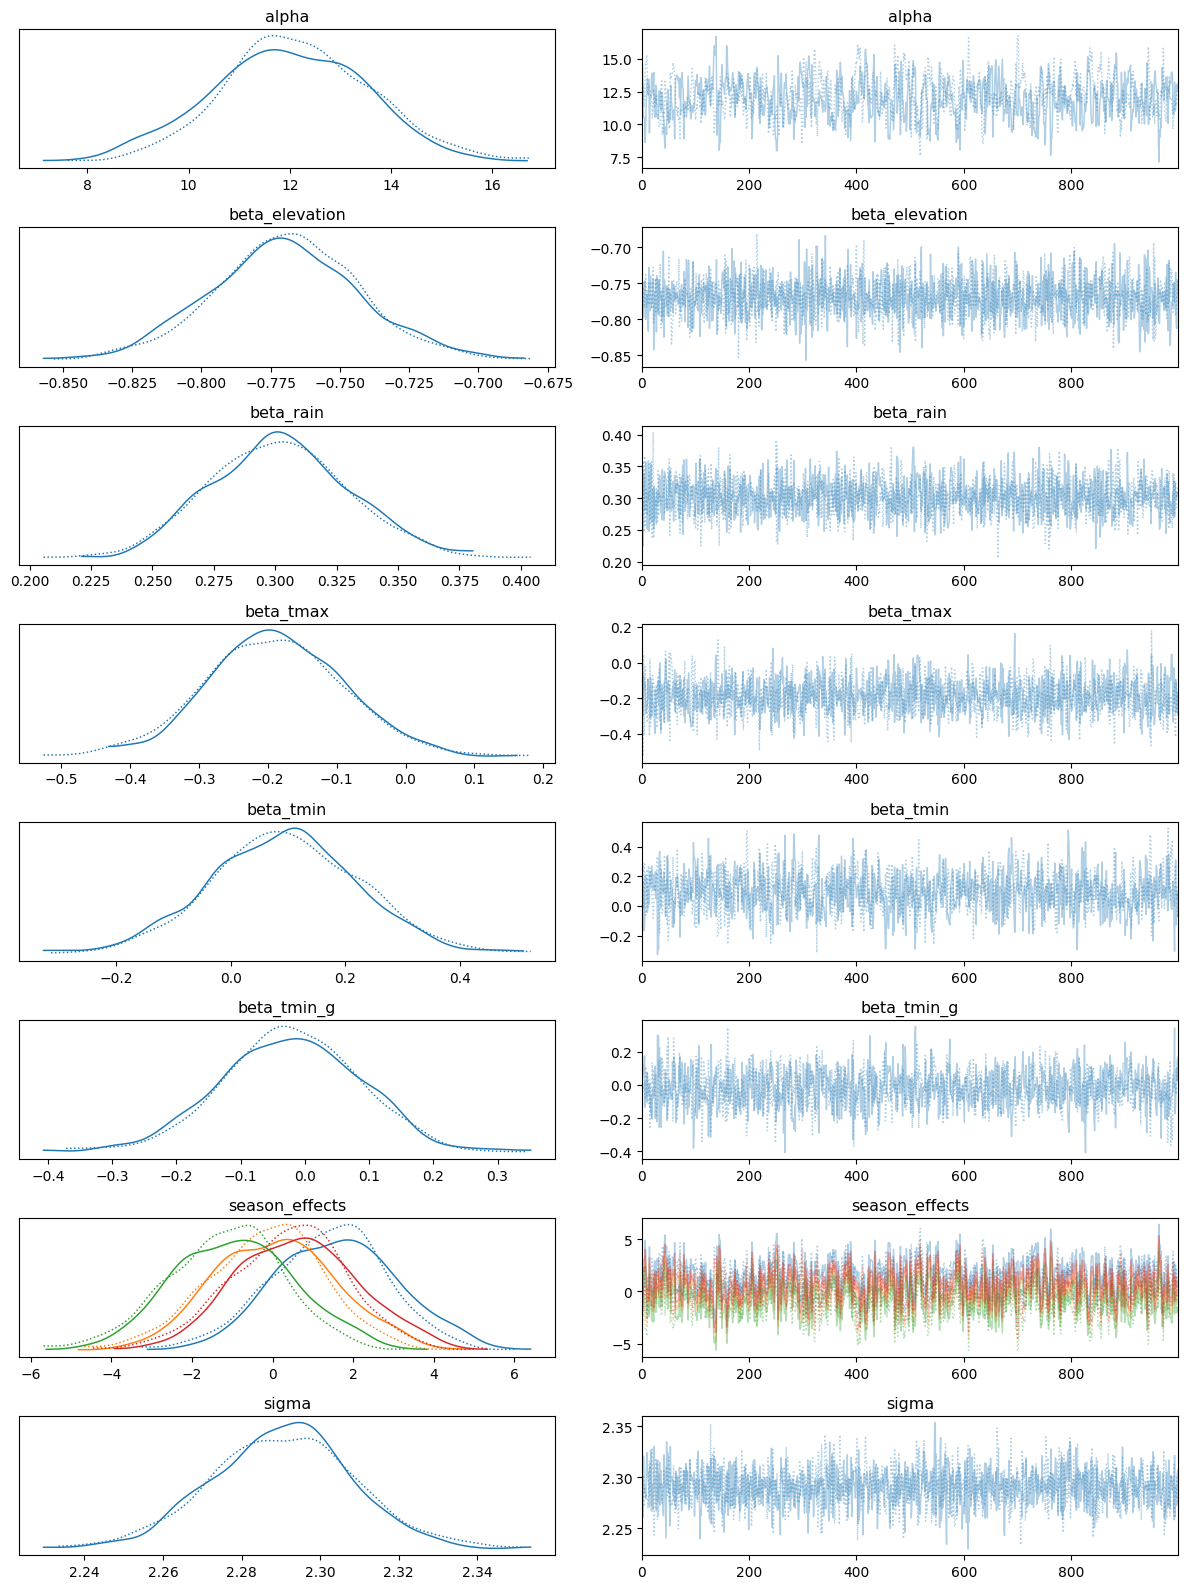

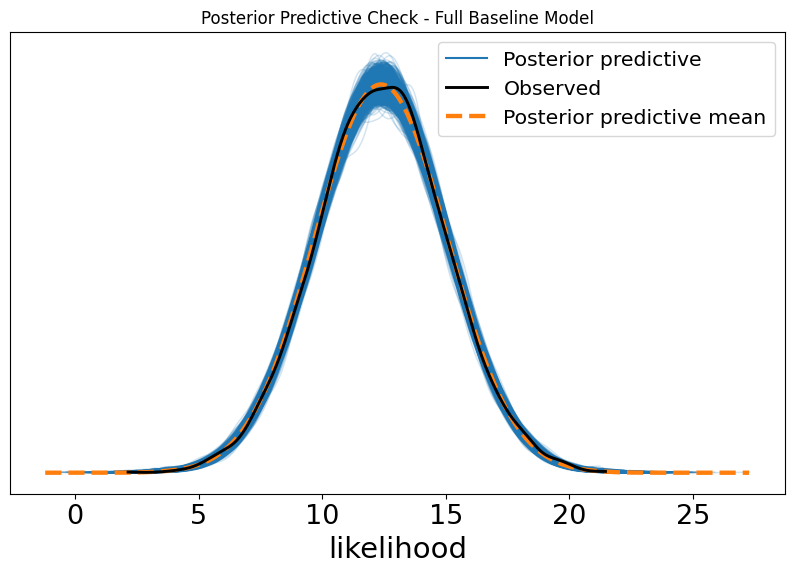

In [ ]:
X_full = combined_df[['RAIN', 'T.MAX', 'T.MIN', 'T.MIN.G', 'ELEVATION']]
X_full_std = (X_full - X_full.mean()) / X_full.std()

with pm.Model() as full_baseline_model:

    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_rain = pm.Normal('beta_rain', mu=0, sigma=1)
    beta_tmax = pm.Normal('beta_tmax', mu=0, sigma=1)
    beta_tmin = pm.Normal('beta_tmin', mu=0, sigma=1)
    beta_tmin_g = pm.Normal('beta_tmin_g', mu=0, sigma=1)
    beta_elevation = pm.Normal('beta_elevation', mu=0, sigma=1)

    # Adding seasons
    season_effects = pm.Normal('season_effects', mu=0, sigma=3, shape=4)
    season_idx = combined_df['SEASON'].values - 1

    sigma = pm.HalfNormal('sigma', sigma=5)

    mu = (
        alpha +
        beta_rain * X_full_std['RAIN'].values +
        beta_tmax * X_full_std['T.MAX'].values +
        beta_tmin * X_full_std['T.MIN'].values +
        beta_tmin_g * X_full_std['T.MIN.G'].values +
        beta_elevation * X_full_std['ELEVATION'].values +
        season_effects[season_idx]
    )


    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)

    full_baseline_trace = pm.sample(1000, tune=1000, return_inferencedata=True,
                                   target_accept=0.95, random_seed=42)

# Convergence diagnostics for full linear model
print("\nFull Model Convergence Diagnostics:")
summary_full_baseline = az.summary(full_baseline_trace)
print(summary_full_baseline)

# Check R-hat values
rhat_vals_full = summary_full_baseline['r_hat'].values
print(f"R-hat range: {rhat_vals_full.min():.3f} to {rhat_vals_full.max():.3f}")
print(f"All parameters converged: {np.all(rhat_vals_full < 1.05)}")

# Visual aids to include in writeup
az.plot_trace(full_baseline_trace)
plt.tight_layout()
plt.savefig('full_baseline_trace.png')


print("\nParameter Recovery (Full Baseline Model):")
print(f"True alpha: {true_alpha:.3f}, Estimated: {float(summary_full_baseline.loc['alpha', 'mean']):.3f}")
print(f"True beta_rain: {true_beta_rain:.3f}, Estimated: {float(summary_full_baseline.loc['beta_rain', 'mean']):.3f}")
print(f"True beta_tmax: {true_beta_tmax:.3f}, Estimated: {float(summary_full_baseline.loc['beta_tmax', 'mean']):.3f}")
print(f"True beta_tmin: {true_beta_tmin:.3f}, Estimated: {float(summary_full_baseline.loc['beta_tmin', 'mean']):.3f}")
print(f"True beta_tmin_g: {true_beta_tmin_g:.3f}, Estimated: {float(summary_full_baseline.loc['beta_tmin_g', 'mean']):.3f}")
print(f"True beta_elevation: {true_beta_elevation:.3f}, Estimated: {float(summary_full_baseline.loc['beta_elevation', 'mean']):.3f}")
print(f"True sigma: {true_sigma:.3f}, Estimated: {float(summary_full_baseline.loc['sigma', 'mean']):.3f}")

# Compare season effects
for i in range(4):
    print(f"Season {i+1} - True: {true_season_effects[i]:.3f}, Estimated: {float(summary_full_baseline.loc[f'season_effects[{i}]', 'mean']):.3f}")

with full_baseline_model:
    full_baseline_ppc = pm.sample_posterior_predictive(full_baseline_trace)

az.plot_ppc(full_baseline_ppc, figsize=(10, 6))
plt.title("Posterior Predictive Check - Full Baseline Model")
plt.savefig('full_baseline_ppc.png')


Also generating some locations predictions using this model.

In [ ]:

alpha_samples = full_baseline_trace.posterior['alpha'].values.flatten()
beta_rain_samples = full_baseline_trace.posterior['beta_rain'].values.flatten()
beta_tmax_samples = full_baseline_trace.posterior['beta_tmax'].values.flatten()
beta_tmin_samples = full_baseline_trace.posterior['beta_tmin'].values.flatten()
beta_tmin_g_samples = full_baseline_trace.posterior['beta_tmin_g'].values.flatten()
beta_elevation_samples = full_baseline_trace.posterior['beta_elevation'].values.flatten()
season_effects_samples = full_baseline_trace.posterior['season_effects'].values.reshape(-1, 4)

# Number of posterior samples
n_samples = len(alpha_samples)

# Create a DataFrame to store location predictions
nh_location_predictions = pd.DataFrame({
    'LOCATION_ID': range(1, n_locations + 1),
    'ELEVATION': locations['ELEVATION'].values,
    'LAT': locations['LAT'].values,
    'LON': locations['LON'].values
})

# calculate predicted wind speed for each location
for loc_id in range(1, n_locations + 1):
    # Filter data for this location
    loc_data = combined_df[combined_df['LOCATION_ID'] == loc_id]

    # Get the mean standardized predictors for this location
    mean_rain_std = loc_data['RAIN'].values.mean() - X_full['RAIN'].mean()
    mean_rain_std /= X_full['RAIN'].std()

    mean_tmax_std = loc_data['T.MAX'].values.mean() - X_full['T.MAX'].mean()
    mean_tmax_std /= X_full['T.MAX'].std()

    mean_tmin_std = loc_data['T.MIN'].values.mean() - X_full['T.MIN'].mean()
    mean_tmin_std /= X_full['T.MIN'].std()

    mean_tmin_g_std = loc_data['T.MIN.G'].values.mean() - X_full['T.MIN.G'].mean()
    mean_tmin_g_std /= X_full['T.MIN.G'].std()

    elevation_std = loc_data['ELEVATION'].values[0] - X_full['ELEVATION'].mean()
    elevation_std /= X_full['ELEVATION'].std()


    season_counts = loc_data['SEASON'].value_counts()
    predominant_season = season_counts.idxmax() - 1

    observed_wind = loc_data['WIND'].mean()


    predicted_winds = []
    for i in range(n_samples):
        pred_wind = (
            alpha_samples[i] +
            beta_rain_samples[i] * mean_rain_std +
            beta_tmax_samples[i] * mean_tmax_std +
            beta_tmin_samples[i] * mean_tmin_std +
            beta_tmin_g_samples[i] * mean_tmin_g_std +
            beta_elevation_samples[i] * elevation_std +
            season_effects_samples[i, predominant_season]
        )
        predicted_winds.append(pred_wind)

    # Calculate mean predicted wind
    mean_predicted_wind = np.mean(predicted_winds)
    wind_potential = mean_predicted_wind**3

    # Store in the Dataframe
    nh_location_predictions.loc[loc_id-1, 'OBSERVED_WIND'] = observed_wind
    nh_location_predictions.loc[loc_id-1, 'PREDICTED_WIND'] = mean_predicted_wind
    nh_location_predictions.loc[loc_id-1, 'WIND_POTENTIAL'] = wind_potential

nh_location_predictions = nh_location_predictions.sort_values('WIND_POTENTIAL', ascending=False)

# Display top locations for wind power using non-hierarchical model
print("\nTop 5 Locations for Wind Power Generation (Non-Hierarchical Model):")
print(nh_location_predictions.head(5))


Top 5 Locations for Wind Power Generation (Non-Hierarchical Model):
    LOCATION_ID  ELEVATION        LAT       LON  OBSERVED_WIND  \
9            10  23.225206  50.517560 -0.349339      13.167386   
12           13  32.525796  51.040136  0.657475      12.524430   
1             2  69.746930  50.609228  0.550266      11.861969   
11           12  85.262062  50.623422 -0.457302      11.641380   
6             7  99.836891  50.990354 -0.823015      14.619486   

    PREDICTED_WIND  WIND_POTENTIAL  
9        13.063419     2229.310690  
12       13.026141     2210.280337  
1        12.841893     2117.810592  
11       12.776809     2085.773943  
6        12.692958     2044.977580  


Now, we can build the hirarcical model. This model uses every parameter

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:01

<ipython-input-6-71b8d063291b>:100: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('hierarchical_ppc.png')



Correlation between true and estimated location intercepts: 0.809


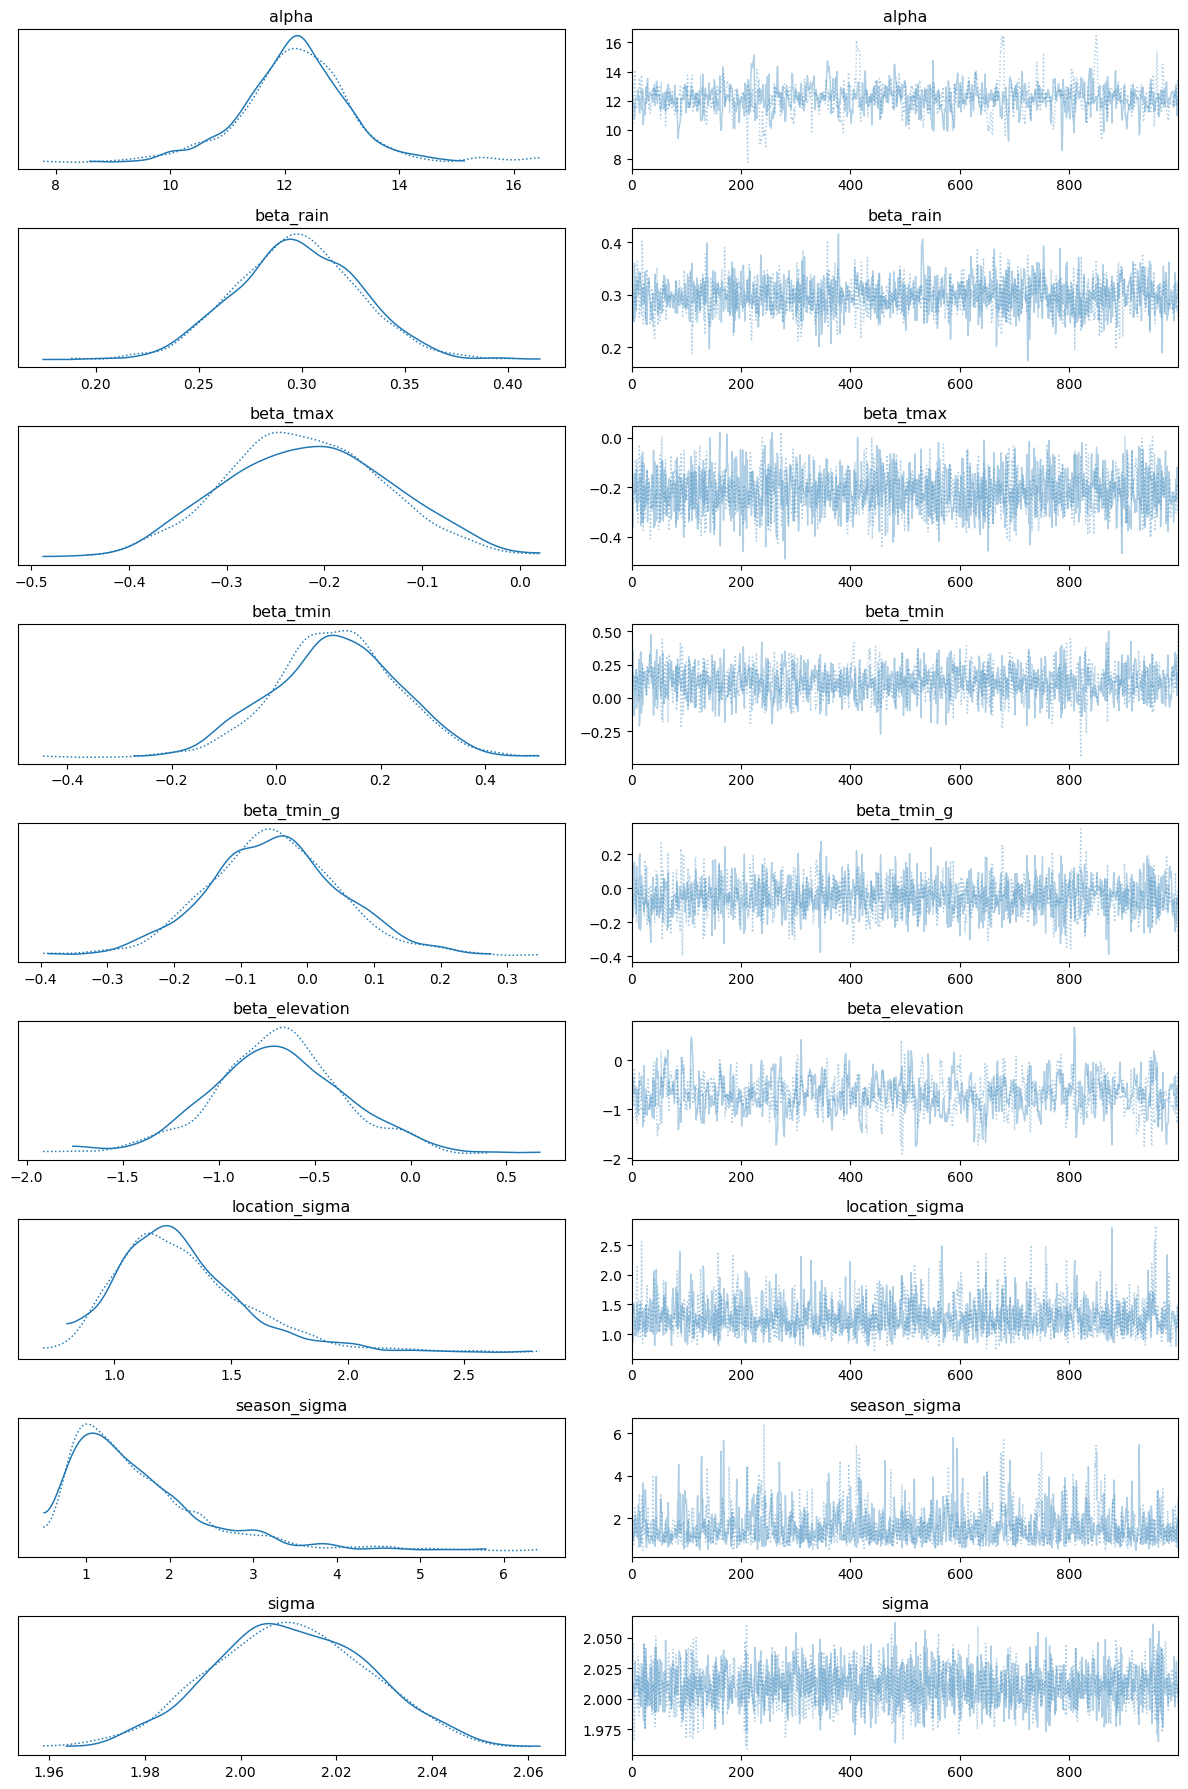

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


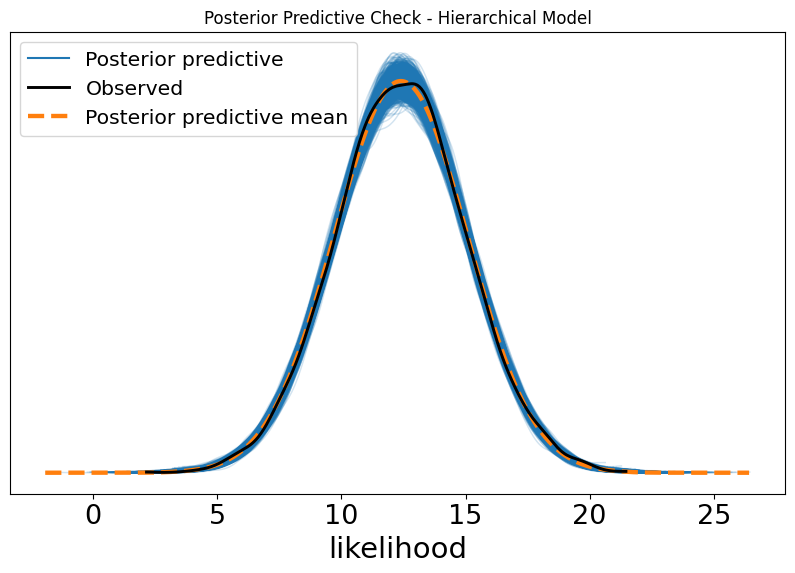

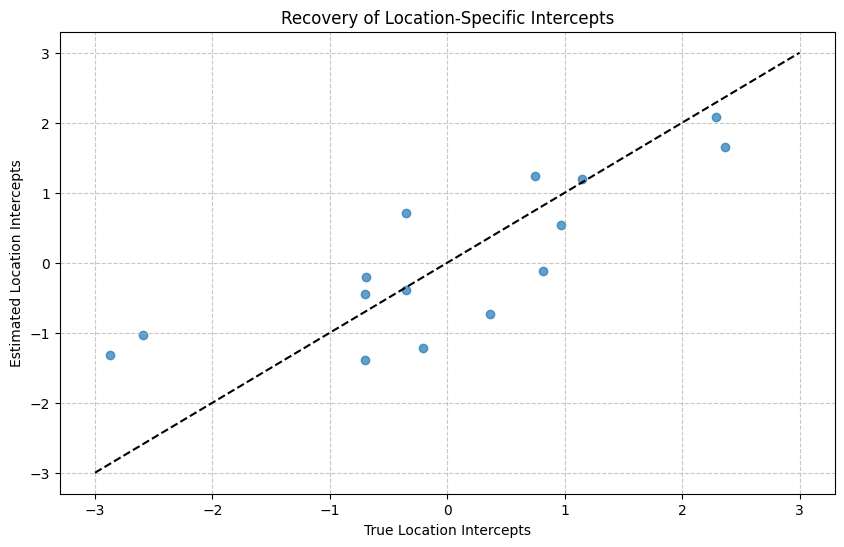

In [ ]:
# Getting all information
location_ids = combined_df['LOCATION_ID'].values
unique_locations = np.unique(location_ids)
n_locations = len(unique_locations)

season_ids = combined_df['SEASON'].values
unique_seasons = np.unique(season_ids)
n_seasons = len(unique_seasons)

with pm.Model() as hierarchical_model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Location-specific random intercepts
    location_sigma = pm.HalfNormal('location_sigma', sigma=3)
    location_intercepts = pm.Normal('location_intercepts', mu=0, sigma=location_sigma, shape=n_locations)

    # Season effects
    season_sigma = pm.HalfNormal('season_sigma', sigma=3)
    season_effects = pm.Normal('season_effects', mu=0, sigma=season_sigma, shape=n_seasons)

    # Fixed effects for weather variables
    beta_rain = pm.Normal('beta_rain', mu=0, sigma=1)
    beta_tmax = pm.Normal('beta_tmax', mu=0, sigma=1)
    beta_tmin = pm.Normal('beta_tmin', mu=0, sigma=1)
    beta_tmin_g = pm.Normal('beta_tmin_g', mu=0, sigma=1)
    beta_elevation = pm.Normal('beta_elevation', mu=0, sigma=1)

    # Location-specific rain effects (varying slopes)
    location_rain_sigma = pm.HalfNormal('location_rain_sigma', sigma=1)
    location_rain_effects = pm.Normal('location_rain_effects', mu=0, sigma=location_rain_sigma, shape=n_locations)

    # Observation error
    sigma = pm.HalfNormal('sigma', sigma=5)

    # Full hierarchical model
    mu = (
        alpha +
        location_intercepts[location_ids-1] +
        season_effects[season_ids-1] +
        beta_rain * X_full_std['RAIN'].values +
        location_rain_effects[location_ids-1] * X_full_std['RAIN'].values +
        beta_tmax * X_full_std['T.MAX'].values +
        beta_tmin * X_full_std['T.MIN'].values +
        beta_tmin_g * X_full_std['T.MIN.G'].values +
        beta_elevation * X_full_std['ELEVATION'].values
    )

    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)

    # Sample from the posterior
    hierarchical_trace = pm.sample(1000, tune=1000, return_inferencedata=True,
                                  target_accept=0.95, random_seed=42)

# Convergence diagnostics for hierarchical model
print("\nHierarchical Model Convergence Diagnostics:")
summary_hierarchical = az.summary(hierarchical_trace, var_names=['alpha', 'beta_rain', 'beta_tmax',
                                                                'beta_tmin', 'beta_tmin_g', 'beta_elevation',
                                                                'location_sigma', 'season_sigma', 'sigma'])
print(summary_hierarchical)

# Check R-hat values for key parameters
rhat_vals_hier = summary_hierarchical['r_hat'].values
print(f"R-hat range for key parameters: {rhat_vals_hier.min():.3f} to {rhat_vals_hier.max():.3f}")
print(f"All key parameters converged: {np.all(rhat_vals_hier < 1.05)}")

# Visual diagnostics
az.plot_trace(hierarchical_trace, var_names=['alpha', 'beta_rain', 'beta_tmax',
                                            'beta_tmin', 'beta_tmin_g', 'beta_elevation',
                                            'location_sigma', 'season_sigma', 'sigma'])
plt.tight_layout()
plt.savefig('hierarchical_trace.png')

# Check for divergences
divergences = hierarchical_trace.sample_stats.diverging.sum()
n_samples = hierarchical_trace.sample_stats.diverging.size
print(f"\nDivergences: {divergences} of {n_samples} ({divergences/n_samples:.1%})")

if divergences > 0:
    print("This model is not accurate")

# Parameter recovery for hierarchical model
print("\nParameter Recovery (Hierarchical Model):")
print(f"True alpha: {true_alpha:.3f}, Estimated: {float(summary_hierarchical.loc['alpha', 'mean']):.3f}")
print(f"True beta_rain: {true_beta_rain:.3f}, Estimated: {float(summary_hierarchical.loc['beta_rain', 'mean']):.3f}")
print(f"True beta_tmax: {true_beta_tmax:.3f}, Estimated: {float(summary_hierarchical.loc['beta_tmax', 'mean']):.3f}")
print(f"True beta_tmin: {true_beta_tmin:.3f}, Estimated: {float(summary_hierarchical.loc['beta_tmin', 'mean']):.3f}")
print(f"True beta_tmin_g: {true_beta_tmin_g:.3f}, Estimated: {float(summary_hierarchical.loc['beta_tmin_g', 'mean']):.3f}")
print(f"True beta_elevation: {true_beta_elevation:.3f}, Estimated: {float(summary_hierarchical.loc['beta_elevation', 'mean']):.3f}")
print(f"True sigma: {true_sigma:.3f}, Estimated: {float(summary_hierarchical.loc['sigma', 'mean']):.3f}")
print(f"True location_sigma: {true_location_sigmas:.3f}, Estimated: {float(summary_hierarchical.loc['location_sigma', 'mean']):.3f}")

# Posterior predictive check for hierarchical model
with hierarchical_model:
    hierarchical_ppc = pm.sample_posterior_predictive(hierarchical_trace)

az.plot_ppc(hierarchical_ppc, figsize=(10, 6))
plt.title("Posterior Predictive Check - Hierarchical Model")
plt.savefig('hierarchical_ppc.png')

# Compare estimated location intercepts to true values
location_intercepts_est = hierarchical_trace.posterior['location_intercepts'].mean(dim=('chain', 'draw')).values

plt.figure(figsize=(10, 6))
plt.scatter(true_location_intercepts, location_intercepts_est, alpha=0.7)
plt.plot([-3, 3], [-3, 3], 'k--')
plt.xlabel('True Location Intercepts')
plt.ylabel('Estimated Location Intercepts')
plt.title('Recovery of Location-Specific Intercepts')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('location_intercepts_recovery.png')

# Calculate correlation between true and estimated location intercepts
loc_int_corr = np.corrcoef(true_location_intercepts, location_intercepts_est)[0, 1]
print(f"\nCorrelation between true and estimated location intercepts: {loc_int_corr:.3f}")

Here are the results from the heirarical model


Parameter Recovery Comparison (% Error):
Parameter | Baseline Model | Full Baseline | Hierarchical
------------------------------------------------------------
alpha        |             3.2% |          0.5% |         1.5%
beta_rain    |            12.3% |          0.7% |        -0.7%
beta_tmax    |            26.0% |         -5.5% |         8.5%
beta_tmin    | N/A             |         -5.0% |        14.0%
beta_tmin_g  | N/A             |        -54.0% |        -0.0%
beta_elevation | N/A             |       -612.7% |      -560.0%
sigma        |            28.7% |         14.5% |         0.5%

Uncertainty (95% Credible Interval Width):
Parameter | Baseline Model | Full Baseline | Hierarchical
------------------------------------------------------------
alpha        |           0.112 |        5.676 |       3.716
beta_rain    |           0.115 |        0.104 |       0.114
beta_tmax    |           0.115 |        0.370 |       0.312
beta_tmin    | N/A             |        0.488 |       0.

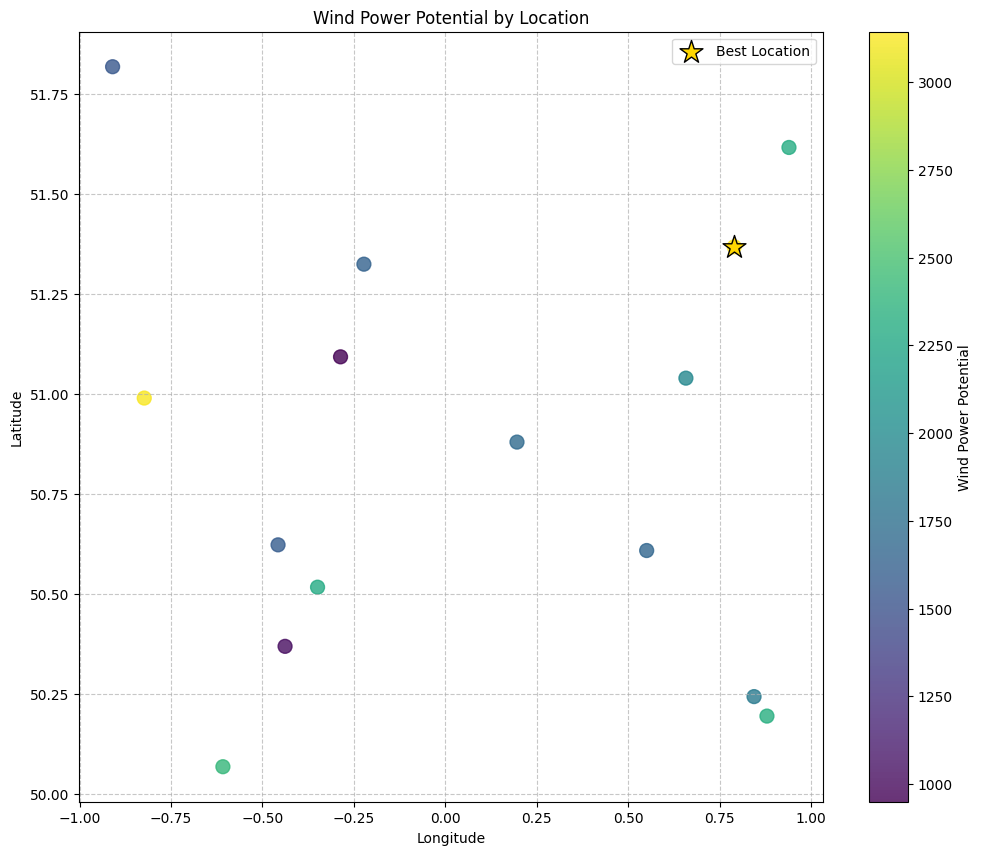

In [ ]:
# Calculate parameter recovery error
def param_recovery_error(true_val, est_val):
    return (est_val - true_val) / true_val * 100

# Compare parameter recovery across models
print("\nParameter Recovery Comparison (% Error):")
print("Parameter | Baseline Model | Full Baseline | Hierarchical")
print("-" * 60)

params_to_compare = [
    ('alpha', true_alpha),
    ('beta_rain', true_beta_rain),
    ('beta_tmax', true_beta_tmax),
    ('beta_tmin', true_beta_tmin),
    ('beta_tmin_g', true_beta_tmin_g),
    ('beta_elevation', true_beta_elevation),
    ('sigma', true_sigma)
]

for param_name, true_val in params_to_compare:
    if param_name in summary_baseline.index:
        baseline_error = param_recovery_error(true_val, float(summary_baseline.loc[param_name, 'mean']))
    else:
        baseline_error = "N/A"

    if param_name in summary_full_baseline.index:
        full_baseline_error = param_recovery_error(true_val, float(summary_full_baseline.loc[param_name, 'mean']))
    else:
        full_baseline_error = "N/A"

    hierarchical_error = param_recovery_error(true_val, float(summary_hierarchical.loc[param_name, 'mean']))

    if isinstance(baseline_error, str):
        print(f"{param_name:12} | {baseline_error:15} | {full_baseline_error:12.1f}% | {hierarchical_error:11.1f}%")
    elif isinstance(full_baseline_error, str):
        print(f"{param_name:12} | {baseline_error:15.1f}% | {full_baseline_error:12} | {hierarchical_error:11.1f}%")
    else:
        print(f"{param_name:12} | {baseline_error:15.1f}% | {full_baseline_error:12.1f}% | {hierarchical_error:11.1f}%")

# Compare credible interval width to measure uncertainty reduction
print("\nUncertainty (95% Credible Interval Width):")
print("Parameter | Baseline Model | Full Baseline | Hierarchical")
print("-" * 60)

for param_name, _ in params_to_compare:
    if param_name in summary_baseline.index:
        baseline_width = float(summary_baseline.loc[param_name, 'hdi_97%']) - float(summary_baseline.loc[param_name, 'hdi_3%'])
    else:
        baseline_width = "N/A"

    if param_name in summary_full_baseline.index:
        full_baseline_width = float(summary_full_baseline.loc[param_name, 'hdi_97%']) - float(summary_full_baseline.loc[param_name, 'hdi_3%'])
    else:
        full_baseline_width = "N/A"

    hierarchical_width = float(summary_hierarchical.loc[param_name, 'hdi_97%']) - float(summary_hierarchical.loc[param_name, 'hdi_3%'])

    if isinstance(baseline_width, str):
        print(f"{param_name:12} | {baseline_width:15} | {full_baseline_width:12.3f} | {hierarchical_width:11.3f}")
    elif isinstance(full_baseline_width, str):
        print(f"{param_name:12} | {baseline_width:15.3f} | {full_baseline_width:12} | {hierarchical_width:11.3f}")
    else:
        print(f"{param_name:12} | {baseline_width:15.3f} | {full_baseline_width:12.3f} | {hierarchical_width:11.3f}")

# Get all posterior samples
posterior_samples = hierarchical_trace.posterior['alpha'].values.flatten()[:, np.newaxis]
location_effects = hierarchical_trace.posterior['location_intercepts'].values.reshape(-1, n_locations)

# Number of posterior samples
n_samples = len(posterior_samples)

# Calculate wind potential for each location using all posterior samples
location_wind_potential = pd.DataFrame({
    'LOCATION_ID': range(1, n_locations + 1),
    'ELEVATION': locations['ELEVATION'].values,
    'LAT': locations['LAT'].values,
    'LON': locations['LON'].values
})

# Calculate mean predicted wind by locatiom
for loc_id in range(1, n_locations + 1):

    loc_data = combined_df[combined_df['LOCATION_ID'] == loc_id]
    loc_idx = loc_id - 1
    observed_wind = loc_data['WIND'].mean()

    # Calculate mean predicted wind
    loc_intercepts = location_effects[:, loc_idx]
    mean_predicted_wind = (posterior_samples + loc_intercepts[:, np.newaxis]).mean()

    # Calculate wind potential
    wind_potential = observed_wind**3

    # Store in the Dataframe
    location_wind_potential.loc[loc_idx, 'OBSERVED_WIND'] = observed_wind
    location_wind_potential.loc[loc_idx, 'PREDICTED_WIND'] = mean_predicted_wind
    location_wind_potential.loc[loc_idx, 'WIND_POTENTIAL'] = wind_potential

# Rank locations
location_wind_potential = location_wind_potential.sort_values('WIND_POTENTIAL', ascending=False)

# Display top locations
print("\nTop 5 Locations for Wind Power Generation:")
print(location_wind_potential.head(5))
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    location_wind_potential['LON'],
    location_wind_potential['LAT'],
    c=location_wind_potential['WIND_POTENTIAL'],
    s=100,
    cmap='viridis',
    alpha=0.8
)
best_loc = location_wind_potential.iloc[0]
plt.scatter(
    best_loc['LON'],
    best_loc['LAT'],
    marker='*',
    s=300,
    color='gold',
    edgecolor='black',
    label='Best Location'
)
cbar = plt.colorbar(scatter)
cbar.set_label('Wind Power Potential')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Wind Power Potential by Location')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('wind_potential_map.png')

And, additionally, a comparison between the 2 models


Comparing location predictions between models...

Locations with biggest differences in ranking between models:
    LOCATION_ID        LAT       LON   ELEVATION  OBSERVED_WIND  NH_PRED_WIND  \
11           12  50.623422 -0.457302   85.262062      11.641380     12.776809   
1             2  50.609228  0.550266   69.746930      11.861969     12.841893   
0             1  51.616795  0.939169  305.926447      13.199196     11.570641   
7             8  50.068777 -0.608034  257.117219      13.398517     11.850779   
3             4  51.368466  0.789655  183.180922      14.648526     12.237363   

    HIER_PRED_WIND  NH_RANK  HIER_RANK  RANK_DIFF  
11       10.792118      4.0       12.0        8.0  
1        10.957666      3.0       10.0        7.0  
0        13.426370     12.0        5.0        7.0  
7        13.372966      9.0        3.0        6.0  
3        14.267815      7.0        1.0        6.0  

Rank correlation between models: 0.404
Prediction correlation between models: 0.072

To

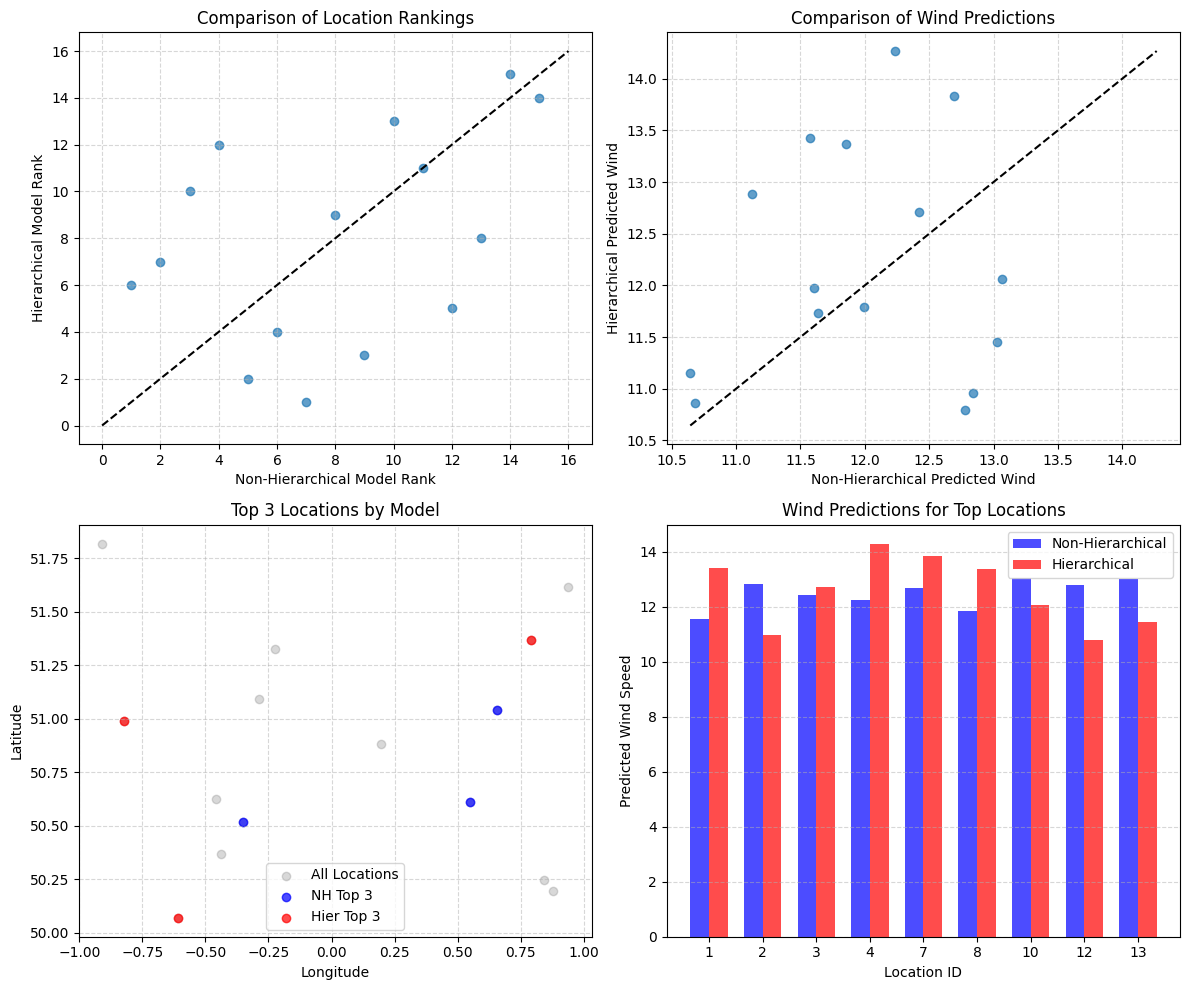

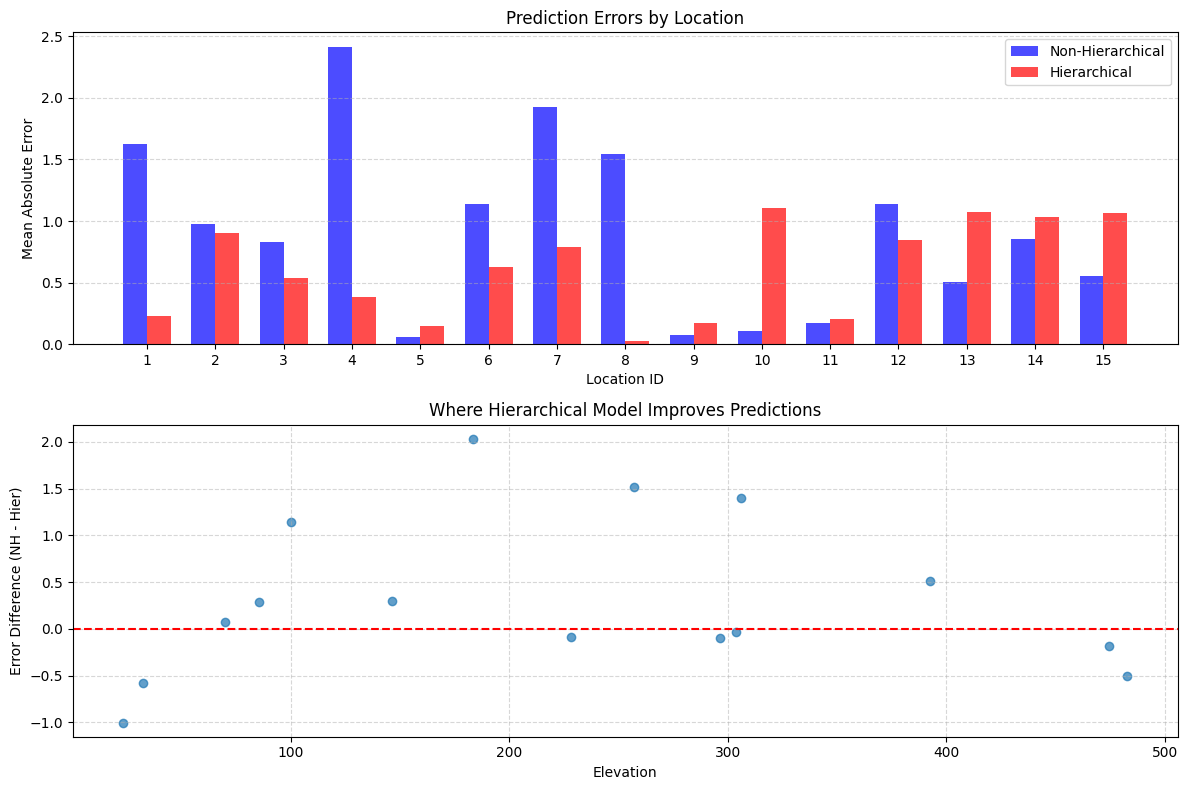

In [ ]:

# Create a comparison Datadframe
location_comparison = pd.DataFrame({
    'LOCATION_ID': range(1, n_locations + 1),
    'LAT': locations['LAT'].values,
    'LON': locations['LON'].values,
    'ELEVATION': locations['ELEVATION'].values,
    'OBSERVED_WIND': combined_df.groupby('LOCATION_ID')['WIND'].mean().values,
    'NH_PRED_WIND': np.nan,
    'HIER_PRED_WIND': np.nan,
    'NH_RANK': np.nan,
    'HIER_RANK': np.nan
})

# Fill in predictions from non-hierarchical model (the one that has all the parameters)
for i, loc_id in enumerate(nh_location_predictions['LOCATION_ID']):
    idx = loc_id - 1
    location_comparison.loc[idx, 'NH_PRED_WIND'] = nh_location_predictions.loc[nh_location_predictions['LOCATION_ID'] == loc_id, 'PREDICTED_WIND'].values[0]
    location_comparison.loc[idx, 'NH_RANK'] = i + 1

# Fill in predictions from hierarchical model
for i, loc_id in enumerate(location_wind_potential['LOCATION_ID']):
    idx = loc_id - 1
    location_comparison.loc[idx, 'HIER_PRED_WIND'] = location_wind_potential.loc[location_wind_potential['LOCATION_ID'] == loc_id, 'PREDICTED_WIND'].values[0]
    location_comparison.loc[idx, 'HIER_RANK'] = i + 1

# Calculate rank differences
location_comparison['RANK_DIFF'] = abs(location_comparison['NH_RANK'] - location_comparison['HIER_RANK'])

# Sort by biggest rank differences
location_comparison_sorted = location_comparison.sort_values('RANK_DIFF', ascending=False)

print("\nLocations with biggest differences in ranking between models:")
print(location_comparison_sorted.head(5))

# Calculate overall agreement metrics
rank_correlation = np.corrcoef(location_comparison['NH_RANK'], location_comparison['HIER_RANK'])[0, 1]
pred_correlation = np.corrcoef(location_comparison['NH_PRED_WIND'], location_comparison['HIER_PRED_WIND'])[0, 1]

print(f"\nRank correlation between models: {rank_correlation:.3f}")
print(f"Prediction correlation between models: {pred_correlation:.3f}")

# Find the top location for each model
nh_top_location = nh_location_predictions.iloc[0]['LOCATION_ID']
hier_top_location = location_wind_potential.iloc[0]['LOCATION_ID']

print(f"\nTop location from non-hierarchical model: {nh_top_location}")
print(f"Top location from hierarchical model: {hier_top_location}")
print(f"Same top recommendation: {'Yes' if nh_top_location == hier_top_location else 'No'}")

# Find agreement in top 3 locations
nh_top3 = set(nh_location_predictions.iloc[:3]['LOCATION_ID'])
hier_top3 = set(location_wind_potential.iloc[:3]['LOCATION_ID'])
top3_agreement = len(nh_top3.intersection(hier_top3))

print(f"Number of locations that appear in top 3 for both models: {top3_agreement} of 3")

# Visualize the comparison
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.scatter(location_comparison['NH_RANK'], location_comparison['HIER_RANK'], alpha=0.7)
plt.plot([0, n_locations + 1], [0, n_locations + 1], 'k--')
plt.xlabel('Non-Hierarchical Model Rank')
plt.ylabel('Hierarchical Model Rank')
plt.title('Comparison of Location Rankings')
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(2, 2, 2)
plt.scatter(location_comparison['NH_PRED_WIND'], location_comparison['HIER_PRED_WIND'], alpha=0.7)
min_val = min(location_comparison['NH_PRED_WIND'].min(), location_comparison['HIER_PRED_WIND'].min())
max_val = max(location_comparison['NH_PRED_WIND'].max(), location_comparison['HIER_PRED_WIND'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--')  # Diagonal line of perfect agreement
plt.xlabel('Non-Hierarchical Predicted Wind')
plt.ylabel('Hierarchical Predicted Wind')
plt.title('Comparison of Wind Predictions')
plt.grid(True, linestyle='--', alpha=0.5)

# Create a map showing the top 3 locations from each model
plt.subplot(2, 2, 3)
# Plot all locations
plt.scatter(location_comparison['LON'], location_comparison['LAT'], alpha=0.3, color='gray', label='All Locations')

# Plot top 3 from non-hierarchical
nh_top3_df = nh_location_predictions.iloc[:3]
plt.scatter(nh_top3_df['LON'], nh_top3_df['LAT'], alpha=0.7, color='blue', label='NH Top 3')

# Plot top 3 from hierarchical
hier_top3_df = location_wind_potential.iloc[:3]
plt.scatter(hier_top3_df['LON'], hier_top3_df['LAT'], alpha=0.7, color='red', label='Hier Top 3')

# Mark locations that appear in both top 3s
for loc_id in nh_top3.intersection(hier_top3):
    loc = location_comparison[location_comparison['LOCATION_ID'] == loc_id]
    plt.scatter(loc['LON'], loc['LAT'], alpha=1.0, color='purple', s=100, label='In Both Top 3' if loc_id == list(nh_top3.intersection(hier_top3))[0] else "")

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Top 3 Locations by Model')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Create a bar chart showing prediction differences for top 5 locations
plt.subplot(2, 2, 4)
top_locations = sorted(list(set(list(nh_location_predictions.iloc[:5]['LOCATION_ID']) + list(location_wind_potential.iloc[:5]['LOCATION_ID']))))
comparison_subset = location_comparison[location_comparison['LOCATION_ID'].isin(top_locations)]

x = np.arange(len(comparison_subset))
width = 0.35

plt.bar(x - width/2, comparison_subset['NH_PRED_WIND'], width, label='Non-Hierarchical', alpha=0.7, color='blue')
plt.bar(x + width/2, comparison_subset['HIER_PRED_WIND'], width, label='Hierarchical', alpha=0.7, color='red')

plt.xlabel('Location ID')
plt.ylabel('Predicted Wind Speed')
plt.title('Wind Predictions for Top Locations')
plt.xticks(x, comparison_subset['LOCATION_ID'])
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')

print("\nAnalyzing prediction differences between models...")

# Calculate prediction differences
location_comparison['PRED_DIFF'] = location_comparison['HIER_PRED_WIND'] - location_comparison['NH_PRED_WIND']
location_comparison['PRED_DIFF_PCT'] = (location_comparison['PRED_DIFF'] / location_comparison['NH_PRED_WIND']) * 100

# Find locations with biggest prediction differences
location_comparison_pred_diff = location_comparison.sort_values('PRED_DIFF_PCT', ascending=False)

print("\nLocations with biggest prediction differences (% diff):")
print(location_comparison_pred_diff[['LOCATION_ID', 'ELEVATION', 'NH_PRED_WIND', 'HIER_PRED_WIND', 'PRED_DIFF_PCT']].head(5))

# Calculate mean absolute error for each model compared to observed wind
location_comparison['NH_MAE'] = abs(location_comparison['NH_PRED_WIND'] - location_comparison['OBSERVED_WIND'])
location_comparison['HIER_MAE'] = abs(location_comparison['HIER_PRED_WIND'] - location_comparison['OBSERVED_WIND'])

mean_nh_mae = location_comparison['NH_MAE'].mean()
mean_hier_mae = location_comparison['HIER_MAE'].mean()

print(f"\nMean Absolute Error (Non-Hierarchical): {mean_nh_mae:.3f}")
print(f"Mean Absolute Error (Hierarchical): {mean_hier_mae:.3f}")
print(f"Improvement with hierarchical model: {(1 - mean_hier_mae/mean_nh_mae)*100:.1f}%")

# Create a visualization of prediction errors
plt.figure(figsize=(12, 8))

# Plot prediction errors by location
plt.subplot(2, 1, 1)
x = np.arange(n_locations)
width = 0.35

plt.bar(x - width/2, location_comparison['NH_MAE'], width, label='Non-Hierarchical', alpha=0.7, color='blue')
plt.bar(x + width/2, location_comparison['HIER_MAE'], width, label='Hierarchical', alpha=0.7, color='red')

plt.xlabel('Location ID')
plt.ylabel('Mean Absolute Error')
plt.title('Prediction Errors by Location')
plt.xticks(x, location_comparison['LOCATION_ID'])
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# Plot error differences vs elevation
plt.subplot(2, 1, 2)
plt.scatter(location_comparison['ELEVATION'],
            location_comparison['NH_MAE'] - location_comparison['HIER_MAE'],
            alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Elevation')
plt.ylabel('Error Difference (NH - Hier)')
plt.title('Where Hierarchical Model Improves Predictions')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('prediction_errors.png', dpi=300, bbox_inches='tight')

I want to contextualize how important it is to have a more useful/accurate model. Thus, here is some code with basic prices to help visualize how much more expensive a windmill would be using it in a non-optimal spot.


In [ ]:

avg_windmill_power = 2.5  # Megawatt per windmill
windmill_cost = 2000000   # $2 million per windmill installation
electricity_price = 50    # $50 per MWh
windmill_lifetime = 20    # 20 years

# For the top location in each model, calculate expected power generation
nh_top_loc = nh_location_predictions.iloc[0]
hier_top_loc = location_wind_potential.iloc[0]

nh_wind = nh_top_loc['PREDICTED_WIND']
hier_wind = hier_top_loc['PREDICTED_WIND']

# If we incorrectly place windmill based on non-hierarchical model when hierarchical is more accurate
if nh_top_loc['LOCATION_ID'] != hier_top_loc['LOCATION_ID']:
    nh_loc_id = nh_top_loc['LOCATION_ID']
    hier_pred_for_nh_loc = location_comparison.loc[location_comparison['LOCATION_ID'] == nh_loc_id, 'HIER_PRED_WIND'].values[0]

    # Calculate power difference based on wind
    correct_power = hier_top_loc['PREDICTED_WIND']**3
    incorrect_power = hier_pred_for_nh_loc**3
    power_ratio = incorrect_power / correct_power

    # Calculate financial impact
    expected_annual_production_optimal = avg_windmill_power * 8760 * 0.35
    expected_annual_revenue_optimal = expected_annual_production_optimal * electricity_price

    expected_annual_production_suboptimal = expected_annual_production_optimal * power_ratio
    expected_annual_revenue_suboptimal = expected_annual_production_suboptimal * electricity_price

    annual_revenue_loss = expected_annual_revenue_optimal - expected_annual_revenue_suboptimal
    lifetime_revenue_loss = annual_revenue_loss * windmill_lifetime

    print(f"\nIf windmill is placed based on non-hierarchical model recommendation:")
    print(f"- Heirarchical model: Location {hier_top_loc['LOCATION_ID']}")
    print(f"- Non-hierarchical model: Location {nh_loc_id}")
    print(f"- Predicted power ratio: {power_ratio:.2f} (suboptimal/optimal)")
    print(f"- Estimated annual revenue loss: ${annual_revenue_loss:,.2f}")
    print(f"- Estimated lifetime revenue loss: ${lifetime_revenue_loss:,.2f}")
    print(f"- Percentage of windmill installation cost: {(lifetime_revenue_loss/windmill_cost)*100:.1f}%")

    if lifetime_revenue_loss > windmill_cost:
        print("CONCLUSION: The revenue loss exceeds the cost of the windmill installation!")
    else:
        print(f"CONCLUSION: The revenue loss is equivalent to {lifetime_revenue_loss/windmill_cost:.1%} of the windmill installation cost.")


If windmill is placed based on non-hierarchical model recommendation:
- Heirarchical model: Location 4.0
- Non-hierarchical model: Location 10.0
- Predicted power ratio: 0.60 (suboptimal/optimal)
- Estimated annual revenue loss: $151,780.67
- Estimated lifetime revenue loss: $3,035,613.32
- Percentage of windmill installation cost: 151.8%
CONCLUSION: The revenue loss exceeds the cost of the windmill installation!
